In [137]:
import cv2
import glob
import matplotlib
import os
import scipy
import shutil
import skimage
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from monai.metrics import compute_hausdorff_distance
from scipy.stats import chi2_contingency, mannwhitneyu, pearsonr
from sewar.full_ref import ergas, hausdorff_distance
from skimage.metrics import normalized_mutual_information as nmi
from sklearn.linear_model import LinearRegression
from statsmodels.stats.multitest import fdrcorrection

In [2]:
def cogniprint(df_h):
    c_list = []
    for c in df_h.columns[10:22]:
        c_list.append(df_h[c].sum())
    #select responses
    diff_df = pd.DataFrame(df_h.columns[10:22], columns = ['test'])
    diff_df['n_correct'] = c_list
    diff_df.sort_values('n_correct', ascending=False, inplace=True)
    diff_df.reset_index(inplace=True)
    # empty matrix
    df_m = pd.DataFrame(np.zeros((12, 8)))
    df_m.index = diff_df['index'] + 1
    df_m.columns = np.arange(1, 9)
    # fill matrix
    for i in df_m.index:
        col_group = df_h.columns[df_h.columns.str.contains(('r'+str(i)+'_'))]
        for col in col_group:
            res = int(col.split('_')[1])
            df_m.at[i,res] = df_h[col].sum()
    df_m2 = df_m.T
    df_m3 = pd.DataFrame()
    for i in df_m2.columns:
        i = str(i)
        df_m3[i] = df_m2.sort_values(int(i), ascending=False).reset_index(drop=True)[int(i)]
    df_m3 = df_m3.T
        
    return df_m3
    

def cogniprint_path(df_h, df_f):
    df_f = df_f.astype(float, errors='ignore')
    df_h = df_h.astype(float, errors='ignore')
    c_list = []
    for c in df_h.columns[10:22]:
        c_list.append(df_h[c].sum())
    #select responses
    diff_df = pd.DataFrame(df_h.columns[10:22], columns = ['test'])
    diff_df['n_correct'] = c_list
    diff_df.sort_values('n_correct', ascending=False, inplace=True)
    diff_df.reset_index(inplace=True)
    # empty matrix
    df_hm = pd.DataFrame(np.zeros((12, 8)))
    df_hm.index = diff_df['index'] + 1
    df_hm.columns = np.arange(1, 9)
    df_m = df_hm.copy()
    # fill matrix
    for i in df_hm.index:
        col_group = df_h.columns[df_h.columns.str.contains(('r'+str(i)+'_'))]
        for col in col_group:
            res = int(col.split('_')[1])
            df_hm.at[i,res] = df_h[col].sum()
    df_hm2 = df_hm.T
    df_hm3 = pd.DataFrame()
    # fill path matrix
    for i in df_m.index:
        col_group = df_h.columns[df_h.columns.str.contains(('r'+str(i)+'_'))]
        for col in col_group:
            res = int(col.split('_')[1])
            df_m.at[i,res] = df_f[col].sum()
    df_m2 = df_m.T
    df_m3 = pd.DataFrame()
    #reindex path test to healthy
    for i in df_hm2.columns:
        i = str(i)
        healthy_col = df_hm2.sort_values(int(i), ascending=False)
        path_col = pd.DataFrame(df_m2[int(i)].reindex(index=healthy_col.index))
        df_hm3[i] = healthy_col.reset_index(drop=True)[int(i)]
        df_m3[i] = path_col.reset_index(drop=True)[int(i)]
    df_m3 = df_m3.T
    #refill matrix with pathological results
        
    return df_m3


def cogni_stats(df_h, df_f, cogni_h, cogni_f):   
    # empty matrix
    df_stats_f = pd.DataFrame(np.zeros((12, 8)))
    df_stats_f.index = cogni_f.index
    df_stats_f.columns = np.arange(1, 9)

    for i in range(0,12):
        for j in range(0,8):
            count = [cogni_f.iloc[i,j], cogni_h.iloc[i,j]]
            nobs = [len(df_f), len(df_h)]
            stat, pval = proportions_ztest(count, nobs)
            df_stats_f.at[(i+1),(j+1)] = pval
    df_stats_f = df_stats_f.iloc[12:]
    df_stats_f.index = cogni_f.index
            
    return df_stats_f


def register_forms(img1, img2):    # img2 is the standard that forms are registered to
    height, width = img2.shape
    # Use ORB algorithm to find location and identity of features matching between documents
    # ORB is open source
    try:
        orb_detector = cv2.ORB_create(5000) #was 5000
        kp1, d1 = orb_detector.detectAndCompute(img1, None)
        kp2, d2 = orb_detector.detectAndCompute(img2, None)
        # Matching keypoints are created by drawing a line between them. There will be 20-30% incorrect matches.
        # we use Hamming distance as a measure of similarity between two features
        # number of bits required to make one feature identical to the other
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) # was cv2.NORM_HAMMING, True
        matches = matcher.match(d1, d2)
        # sort matches by score
        no_of_matches = len(matches)
        p1 = np.zeros((no_of_matches, 2))
        p2 = np.zeros((no_of_matches, 2))
        for i in range(len(matches)):
            p1[i, :] = kp1[matches[i].queryIdx].pt
            p2[i, :] = kp2[matches[i].trainIdx].pt
        # calculate homography using Random Sample Consensus (RANSAC)
        homography, mask = cv2.findHomography(p1, p2, cv2.RANSAC)
        # Transform by warping second onto first image pixel by pixel
        transformed_img = cv2.warpPerspective(img1,homography, (width, height), 
                                              cv2.INTER_CUBIC, cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
       # print('registered')
    except:
     #   print('registration not possible')
        transformed_img = img1
        homography = np.nan

    return transformed_img, homography


def register_ims(files):    
    list_test = []
    list_tim = []
    for f in files['test'].unique():
        lama_im = files[(files.test == f) & (files.code == 'lama')]
        b = cv2.imread(lama_im.filepath.values[0], cv2.IMREAD_GRAYSCALE)
        for j in files['code'].unique():
            index_im = files[(files.test == f) & (files.code == j)]
            list_test.append(index_im.filename.values[0])
            a = cv2.imread(index_im.filepath.values[0], cv2.IMREAD_GRAYSCALE)
            trans_img, _ = register_forms(a,b)
            list_tim.append(trans_img)
    results = dict(zip(list_test, list_tim))
    res_df = pd.DataFrame([results]).T
    res_df.reset_index(inplace=True)
    res_df.columns = ['filename', 't_im']
    files = files.merge(res_df, on='filename')
    
    return files


def register_crops(files):
    list_test = []
    list_tim = []
    for f in files['test'].unique():
        lama_im = files[(files.test == f) & (files.code == 'lama')]
        b = lama_im.crop.values[0]
        for j in files['code'].unique():
            index_im = files[(files.test == f) & (files.code == j)]
            list_test.append(index_im.filename.values[0])
            a = index_im.crop.values[0]
            trans_img, _ = register_forms(a,b)
            list_tim.append(trans_img)
    results = dict(zip(list_test, list_tim))
    res_df = pd.DataFrame([results]).T
    res_df.reset_index(inplace=True)
    res_df.columns = ['filename', 't_crop']
    files = files.merge(res_df, on='filename')


def try_bw_conv(x):
    try:
        x = cv2.threshold(x, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    except:
        x = np.nan
    return x


def crop_registered_orig(files):
    files['crop'] = 0
    files.loc[files.test == 1, 'crop'] = files[files.test == 1].t_im.apply(lambda x: x[180:270, 200:340])
    files.loc[files.test == 2, 'crop'] = files[files.test == 2].t_im.apply(lambda x: x[190:275, 210:320])
    files.loc[files.test == 3, 'crop'] = files[files.test == 3].t_im.apply(lambda x: x[190:270, 210:310])
    files.loc[files.test == 4, 'crop'] = files[files.test == 4].t_im.apply(lambda x: x[190:285, 210:330])
    files.loc[files.test == 5, 'crop'] = files[files.test == 5].t_im.apply(lambda x: x[210:285, 230:320])
    files.loc[files.test == 6, 'crop'] = files[files.test == 6].t_im.apply(lambda x: x[180:265, 250:340])
    files.loc[files.test == 7, 'crop'] = files[files.test == 7].t_im.apply(lambda x: x[200:280, 220:300])
    files.loc[files.test == 8, 'crop'] = files[files.test == 8].t_im.apply(lambda x: x[200:280, 230:320])
    files.loc[files.test == 9, 'crop'] = files[files.test == 9].t_im.apply(lambda x: x[190:280, 220:310])
    files.loc[files.test == 10, 'crop'] = files[files.test == 10].t_im.apply(lambda x: x[210:290, 230:310])
    files.loc[files.test == 11, 'crop'] = files[files.test == 11].t_im.apply(lambda x: x[210:290, 210:310])
    files.loc[files.test == 12, 'crop'] = files[files.test == 12].t_im.apply(lambda x: x[210:290, 230:320])
    files['crop_bw'] = files.crop.apply(lambda x: cv2.threshold(x, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1])
    files['crop_bin'] = files['crop_bw']/255
   
    return files


def crop_registered(files):
    files['crop'] = 0
    files.loc[files.test.str[0:2] == '1_', 'crop'] = files[files.test.str[0:2] == '1_'].t_im.apply(lambda x: x[180:270, 210:320])
    files.loc[files.test.str[0] == '2', 'crop'] = files[files.test.str[0] == '2'].t_im.apply(lambda x: x[190:275, 210:320])
    files.loc[files.test.str[0] == '3', 'crop'] = files[files.test.str[0] == '3'].t_im.apply(lambda x: x[190:270, 210:310])
    files.loc[files.test.str[0] == '4', 'crop'] = files[files.test.str[0] == '4'].t_im.apply(lambda x: x[190:285, 210:330])
    files.loc[files.test.str[0] == '5', 'crop'] = files[files.test.str[0] == '5'].t_im.apply(lambda x: x[210:285, 230:320])
    files.loc[files.test.str[0] == '6', 'crop'] = files[files.test.str[0] == '6'].t_im.apply(lambda x: x[180:265, 250:350])
    files.loc[files.test.str[0] == '7', 'crop'] = files[files.test.str[0] == '7'].t_im.apply(lambda x: x[200:280, 220:300])
    files.loc[files.test.str[0] == '8', 'crop'] = files[files.test.str[0] == '8'].t_im.apply(lambda x: x[210:280, 230:320])
    files.loc[files.test.str[0] == '9', 'crop'] = files[files.test.str[0] == '9'].t_im.apply(lambda x: x[190:280, 220:310])
    files.loc[files.test.str[0:2] == '10', 'crop'] = files[files.test.str[0:2] == '10'].t_im.apply(lambda x: x[210:290, 230:310])
    files.loc[files.test.str[0:2] == '11', 'crop'] = files[files.test.str[0:2] == '11'].t_im.apply(lambda x: x[210:290, 210:310])
    files.loc[files.test.str[0:2] == '12', 'crop'] = files[files.test.str[0:2] == '12'].t_im.apply(lambda x: x[210:290, 230:320])
    files['crop_bw'] = files.crop.apply(lambda x: try_bw_conv(x))
    files['crop_bin'] = files['crop_bw']/255

    return files


def get_final_scores_noise(files, metric, ascending=True):
    files['test_no'] = files.test.apply(lambda x: int(x.split('_')[0]))
    files_scores = files[files.code != 'lama'].sort_values(['test_no', 'run', metric], ascending=ascending)
    fs = files_scores.drop_duplicates('test', keep='first')
    fs.reset_index(drop=True, inplace=True)
    gt = files[files.code != 'lama'].sort_values(['test_no', 'run'], ascending=ascending)
    gt.reset_index(drop=True, inplace=True)
    scores = fs['code'].values
    
    return scores


def evaluate_model(inpath):
    
    files = [f for f in glob.iglob(inpath + '**/*.png', recursive=True)]
    files=pd.DataFrame(files, columns=['filepath'])
    files['filename'] = files.filepath.apply(lambda x: x.split('/')[-1])
    files['filename'] = files.filename.apply(lambda x: x.replace('s_', ''))
    files['test'] = files['filename'].apply(lambda x: x.split('_')[0])
    files['test'] = files['test'].apply(lambda x: x[3:])
    files['test'] = files.test.astype(int)
    files['code'] = files['filename'].apply(lambda x: x.split('_')[1])
    files['code'] = files['code'].apply(lambda x: x.split('.')[0])
    files = files.sort_values('test')
    files.reset_index(inplace=True, drop=True)
    files = register_ims(files)
    files = crop_registered_orig(files)
    files['crop_bin_inv'] = (files['crop_bin'] -1) *-1
    files = compute_similarity(files, col='crop_bin', comparison='hausdorff')
    files = compute_similarity(files, col='crop_bin', comparison='earthmovers')
    files = compute_similarity(files, col='crop_bin', comparison='mse')
    files = compute_similarity(files, col='crop_bin', comparison='avg_surface')
    files = compute_similarity(files, col='crop_bin', comparison='ergas')

    return files


def compute_similarity(files, col='t_im', comparison='mse'):
    list_test = []
    list_metric = []
    for f in files['test'].unique():
        lama_im = files[(files.test == f) & (files.code == 'lama')]
        a = lama_im[col].values[0]
        for j in files['code'].unique():
            index_im = files[(files.test == f) & (files.code == j)]
            list_test.append(index_im.filename.values[0])
            b = index_im[col].values[0]
            if comparison == 'mse':
                metric = ((a - b)**2).mean(axis=None)
            if comparison == 'hausdorff':
                metric = compute_hausdorff_distance(a, b, label_idx=0)
            if comparison == 'earthmovers':
                metric = scipy.stats.wasserstein_distance(a.flatten(),b.flatten())
            if comparison == 'ergas':
                metric = ergas(a, b)
            if comparison == 'nmi':
                metric = nmi(a, b)
            list_metric.append(metric)

    results = dict(zip(list_test, list_metric))
    res_df = pd.DataFrame([results]).T
    res_df.reset_index(inplace=True)
    res_df.columns = ['filename', comparison]
    files = files.merge(res_df, on='filename')
    
    return files


def get_total(scores):
    incorrect_list = []
    incorrect_idx = []
    for index, (first, second) in enumerate(zip(correct, scores)):
        if first != second:
            incorrect_idx.append(index)
            incorrect_list.append(second)
    total = 12 - len(incorrect_list)
    return total, incorrect_idx, incorrect_list


def crop_registered_fullsize(files):
    files['crop'] = 0
    files.loc[files.test.str[0:2] == '1_', 'crop'] = files[files.test.str[0:2] == '1_'].t_im.apply(lambda x: x[150:220, 290:380])
    files.loc[files.test.str[0] == '2', 'crop'] = files[files.test.str[0] == '2'].t_im.apply(lambda x: x[160:225, 300:380])
    files.loc[files.test.str[0] == '3', 'crop'] = files[files.test.str[0] == '3'].t_im.apply(lambda x: x[160:225, 290:370])
    files.loc[files.test.str[0] == '4', 'crop'] = files[files.test.str[0] == '4'].t_im.apply(lambda x: x[160:230, 300:380])
    files.loc[files.test.str[0] == '5', 'crop'] = files[files.test.str[0] == '5'].t_im.apply(lambda x: x[160:230, 310:390])
    files.loc[files.test.str[0] == '6', 'crop'] = files[files.test.str[0] == '6'].t_im.apply(lambda x: x[160:220, 320:380])
    files.loc[files.test.str[0] == '7', 'crop'] = files[files.test.str[0] == '7'].t_im.apply(lambda x: x[165:225, 300:355])
    files.loc[files.test.str[0] == '8', 'crop'] = files[files.test.str[0] == '8'].t_im.apply(lambda x: x[160:215, 300:375])
    files.loc[files.test.str[0] == '9', 'crop'] = files[files.test.str[0] == '9'].t_im.apply(lambda x: x[155:225, 310:385])
    files.loc[files.test.str[0:2] == '10', 'crop'] = files[files.test.str[0:2] == '10'].t_im.apply(lambda x: x[155:225, 305:380])
    files.loc[files.test.str[0:2] == '11', 'crop'] = files[files.test.str[0:2] == '11'].t_im.apply(lambda x: x[160:225, 305:375])
    files.loc[files.test.str[0:2] == '12', 'crop'] = files[files.test.str[0:2] == '12'].t_im.apply(lambda x: x[155:225, 305:375])
    files['crop_bw'] = files.crop.apply(lambda x: try_bw_conv(x))
    files['crop_bin'] = files['crop_bw']/255

    return files


def get_final_scores(files, metric):
    files_scores = files[files.code != 'lama'].sort_values(['test', metric])
    fs = files_scores.drop_duplicates('test', keep='first')
    fs.reset_index(drop=True, inplace=True)
    gt = files[files.code != 'lama'].sort_values('test')
    gt.reset_index(drop=True, inplace=True)
    scores = fs['code'].values
    
    return scores

def get_total(scores):
    incorrect_list = []
    incorrect_idx = []
    for index, (first, second) in enumerate(zip(correct, scores)):
        if first != second:
            incorrect_idx.append(index)
            incorrect_list.append(second)
    total = 12 - len(incorrect_list)
    
    return total, incorrect_idx, incorrect_list


def scores_panel(scores):
    meta_list = []
    scores_list = []
    for i in range(0,50):
        run_list = []
        for j in range(0,12):
            x = scores[i + (j*50)]
            run_list.append(x)
        meta_list.append(run_list)
        score, _,_ = get_total(run_list)
        scores_list.append(score)
        
    return meta_list, scores_list


def get_scores_and_duplicates(files):
    files_scores = files[files.code != 'lama'].sort_values(['test', 'hausdorff'])
    fs = files_scores.drop_duplicates('test', keep='first')
    fs.reset_index(drop=True, inplace=True)
    gt = files[files.code != 'lama'].sort_values('test')
    gt.reset_index(drop=True, inplace=True)
    scores = fs['code'].values
    min_hausdorff_map = fs[['test', 'hausdorff']]
    min_hausdorff_map.columns = ['test', 'hausdorff_min']
    min_hausdorff_map.reset_index(drop=True, inplace=True)
    files_scores = files_scores.merge(min_hausdorff_map, on='test')
    files_scores['top_match_hd'] = 0
    files_scores.loc[files_scores.hausdorff == files_scores.hausdorff_min, 'top_match_hd'] = 1
    double_map = files_scores[['test', 'top_match_hd']].groupby('test').sum().reset_index()
    double_map.columns = ['test', 'n_top_hd']
    files_scores = files_scores.merge(double_map, on='test')
    
    return files_scores


def lama_cogniprint(df_h, df_l):

    df_h = df_h.astype(float, errors='ignore')
    c_list = []
    for c in df_h.columns[10:22]:
        c_list.append(df_h[c].sum())
    #select responses
    diff_df = pd.DataFrame(df_h.columns[10:22], columns=['test'])
    diff_df['n_correct'] = c_list
    diff_df.sort_values('n_correct', ascending=False, inplace=True)
    diff_df.reset_index(inplace=True)
    # empty matrix
    df_hm = pd.DataFrame(np.zeros((12, 8)))
    df_hm.index = diff_df['index'] + 1
    df_hm.columns = np.arange(1, 9)
    df_m = df_hm.copy()
    # fill matrix
    for i in df_hm.index:
        col_group = df_h.columns[df_h.columns.str.contains(('r'+str(i)+'_'))]
        for col in col_group:
            res = int(col.split('_')[1])
            df_hm.at[i,res] = df_h[col].sum()
    df_hm2 = df_hm.T
    df_hm3 = pd.DataFrame()
    # fill path matrix
    for i in df_m.index:
        col_group = df_h.columns[df_h.columns.str.contains(('r'+str(i)+'_'))]
        for col in col_group:
            res = int(col.split('_')[1])
            df_m.at[i,res] = df_l[col]
    df_m2 = df_m.T
    df_m3 = pd.DataFrame()
    #reindex path test to healthy
    for i in df_hm2.columns:
        i = str(i)
        healthy_col = df_hm2.sort_values(int(i), ascending=False)
        path_col = pd.DataFrame(df_m2[int(i)].reindex(index=healthy_col.index))
        df_hm3[i] = healthy_col.reset_index(drop=True)[int(i)]
        df_m3[i] = path_col.reset_index(drop=True)[int(i)]
    df_m3 = df_m3.T
    #refill matrix with pathological results

    return df_m3


def add_min_metric(x):
    y = min_h[min_h.test == x].hausdorff
    return y


def create_apm_summary(df):
    c_list = []
    t_list = []
    col_list = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12']

    for col in col_list:
        correct = df[col].sum()
        total = df[col].notna().sum()
        c_list.append(correct)
        t_list.append(total)

    summary_df = pd.DataFrame(col_list)
    summary_df['correct'] = c_list
    summary_df['total'] = t_list
    summary_df['ratio'] = summary_df['correct'] / summary_df['total']
    
    return summary_df

In [166]:
df = pd.read_excel("/media/amy/disk-11/npsy_apm/Raven's healthy controls and frontal and nonfrontal 23 3 23.xlsx")
df = df[df.columns[:32]]
df.columns = ['id', 'group', 'sub_group', 'gender', 'age', 'nart', 'educ_years', 'raven',
              'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'r10', 'r11', 'r12',
              'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12']
cols = ['r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'r10', 'r11', 'r12']
df[cols] = df[cols].replace({'0':np.nan, 0:np.nan, '':np.nan})
df['patient'] = 0
df.loc[df.id.apply(lambda x:len(str(x)) > 3), 'patient'] = 1
df['p1'] = 0
df.loc[df.group == 2, 'p1'] = 1
df['p2'] = 0
df.loc[df.group == 3, 'p2'] = 1
df.loc[df.id.apply(lambda x:len(str(x)) > 3), 'patient'] = 1
#impute known correct if r = nan but c = 1; impute known correct if incorrectly written
correct_list = [8,4,5,1,2,5,6,3,7,8,7,6]
for i in range(0,12):
    c_col = 'c' + str(i+1)
    r_col = 'r' + str(i+1)
    df.loc[((df[r_col].isna()) & (df[c_col] == 1.0)), r_col] = correct_list[i]
    try:
        false_input = df[df[c_col] == 1][r_col].value_counts().index[1]
        correct_input = df[df[c_col] == 1][r_col].value_counts().index[0]
        df.loc[((df[r_col] == false_input) & (df[c_col] == 1.0)), r_col] = correct_input
    except:
        pass
    
df[cols] = df[cols].dropna().astype(int).astype(str)
#remove response nan rows for now
dff = df.copy()
df=df[df.c1.notna()].reset_index(drop=True)

#correlations
df_res = pd.get_dummies(df[['r1','r2','r3','r4','r5','r6','r7','r8','r9','r10','r11','r12']])
df_res['total_responses_coded'] = df_res.sum(axis=1)
df_res = df_res[df_res.total_responses_coded > 0]
df_all = pd.concat([df[['group', 'sub_group', 'patient', 'p1', 'p2', 'gender', 'age', 'nart', 'educ_years', 'raven',
                       'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12']], df_res],axis=1)
df_all = df_all[df_all.total_responses_coded > 0]
df_res.reset_index(inplace=True, drop=True)
df_all.reset_index(inplace=True, drop=True)
df_res.drop('total_responses_coded', axis=1, inplace=True)
df_all.drop('total_responses_coded', axis=1, inplace=True)

#rank correlation with ravens total
correct_r = ['r1_8', 'r2_4', 'r3_5', 'r4_1', 'r5_2', 'r6_5', 'r7_6', 'r8_3', 'r9_7', 'r10_8', 'r11_7', 'r12_6']
c_r = []
for x in correct_r:
    x = x +'_correct'
    c_r.append(x)
name_map = dict(zip(correct_r, c_r))
df_all = df_all.rename(columns=name_map)
df_res.columns = df_all.columns[22:]
corr_all = df_all.corr()
raven_df = pd.DataFrame(corr_all.raven)
raven_df['abs'] =  abs(raven_df['raven'])
raven_df = raven_df.sort_values('abs', ascending=False)
raven_df = raven_df[~raven_df.index.str.contains("correct")]

In [70]:
plot_df = df[(df.sub_group==2) | (df.sub_group==5)]
plot_df['kind'] = 'healthy'
plot_df.loc[plot_df.sub_group == 2, 'kind'] = 'right frontal'

/home/amy/anaconda3/envs/DNA/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/amy/anaconda3/envs/DNA/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [71]:
plot_df = plot_df[['id', 'nart', 'raven', 'kind']]
plot_df.columns = ['ID', 'NART', 'RAPM', 'kind']

/home/amy/anaconda3/envs/DNA/lib/python3.7/site-packages/seaborn/distributions.py:1185: UserWarning: linewidths is ignored by contourf
  **contour_kws,


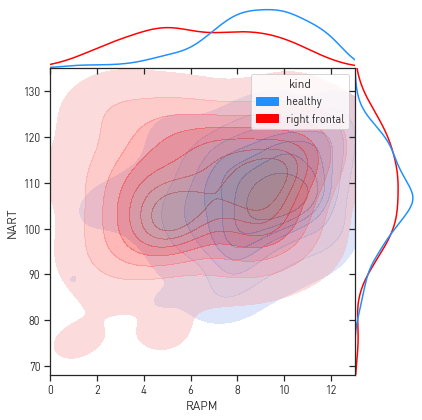

In [123]:
sns.set_theme()
sns.set_style("ticks")
plt.rcParams['font.sans-serif'] = "DinPro"
plt.rcParams['font.family'] = "DinPro"
g = sns.jointplot(data=plot_df, y="NART", x="RAPM", hue='kind', kind='kde',\
                  alpha=0.4, space=0, linewidths=0.6,\
                  levels=8, fill=True, common_norm=False,\
                  palette={'healthy': 'dodgerblue', 'right frontal': 'red'},\
                  marginal_kws=dict(common_norm=False, fill=False, legend=False))
g.ax_marg_y.set_ylim(68, 135)
g.ax_marg_x.set_xlim(0, 13)
#sns.move_legend(g, "lower center")#,plt.legend(loc='upper left')

g.savefig('patient_joint_nart_apm_kde_models_2.svg')

/home/amy/anaconda3/envs/DNA/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/amy/anaconda3/envs/DNA/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


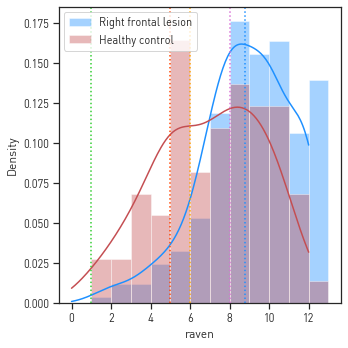

In [125]:
sns.set_theme()
sns.set_style("ticks")
plt.rcParams['font.sans-serif'] = "DinPro"
plt.rcParams['font.family'] = "DinPro"
plt.figure(figsize=(5,5))
sns.distplot(df[df.group==1].raven, color='dodgerblue', bins=np.arange(0,14),kde_kws={'clip': (0.0, 12.0)}, label='Right frontal lesion').set(xlabel='APM score', ylabel='Density')
sns.distplot(df[df.sub_group==2].raven, color='r', bins=np.arange(0,14),kde_kws={'clip': (0.0, 12.0)}, label='Healthy control')#.set(xlabel='APM score', ylabel='Density')
plt.axvline(8.77, 0, color='dodgerblue', linestyle=':')
plt.axvline(8, 0, color='orchid', linestyle=':')
# plt.axvline(8.02, 0, color='orange', linestyle='--', label='Posterior lesion, mean')
# plt.axvline(7.09, 0, color='limegreen', linestyle='--', label='Frontal lesion, mean')
plt.axvline(6, 0, color='orange', linestyle=':')
plt.axvline(5, 0, color='orangered', linestyle=':')
plt.axvline(1, 0, color='limegreen', linestyle=':')
plt.legend()
plt.tight_layout()
plt.savefig('healthy_apm_scores_kde_models_0223_3.svg')

In [115]:
df_hc = df[df.group==1].reset_index(drop=True)
reg = LinearRegression()
reg.fit(np.array(df_hc['raven']).reshape(-1,1), np.array(df_hc['nart']).reshape(-1,1))
corr, p =  pearsonr(df[df.group==1].nart, df[df.group==1].raven) # p = 1.4006427797917533e-07
reg.predict(np.array([1,2,3,4,5,6,7,8,9]).reshape(-1,1))

array([[ 97.4260629 ],
       [ 98.65228438],
       [ 99.87850586],
       [101.10472734],
       [102.33094883],
       [103.55717031],
       [104.78339179],
       [106.00961327],
       [107.23583475]])

In [154]:
df_all['name'] = 'healthy_control'
df_all.loc[df.p1 == 1, 'name'] = 'frontal'
df_all.loc[df.p2 == 1, 'name'] = 'posterior'
df_all['name'] = 'o'
df_all.loc[df.sub_group == 2, 'name'] = 'right_frontal'
df_all_labels = df_all[['gender', 'age', 'nart', 'educ_years', 'raven']]
#drop incorrectly assigned patients
df_h = df_all[df_all.group == 1].reset_index(drop=True)
#select responses
c_list = []
for c in df_h.columns[10:22]:
    c_list.append(df_h[c].sum())
diff_df = pd.DataFrame(df_h.columns[10:22], columns=['test'])
diff_df['n_correct'] = c_list
diff_df.sort_values('n_correct', ascending=False, inplace=True)
diff_df.reset_index(inplace=True)
df_h = df_all[df_all.group == 1].reset_index(drop=True)
df_f = df_all[df_all.p1 == 1].reset_index(drop=True)
df_p = df_all[df_all.p2 == 1].reset_index(drop=True)
df_patient = df_all[~df_all.group == 1].reset_index(drop=True)
cogni_h = cogniprint(df_h)
cogni_f = cogniprint_path(df_h, df_f)
cogni_p = cogniprint_path(df_h, df_p)
df_f1 = df_all[df_all.sub_group == 1].reset_index(drop=True)
df_f2 = df_all[df_all.sub_group == 2].reset_index(drop=True)
cogni_f1 = cogniprint_path(df_h, df_f1)
cogni_f2 = cogniprint_path(df_h, df_f2)
cogni_f.columns = cogni_f.columns + 1
cogni_h.columns = cogni_h.columns + 1
cogni_f1.columns = cogni_f1.columns + 1
cogni_p.columns = cogni_p.columns + 1
cogni_f2.columns = cogni_f2.columns + 1

In [75]:
df.groupby('sub_group').mean()

,group,gender,age,nart,educ_years,raven,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,patient,p1,p2
sub_group,,,,,,,,,,,,,,,,,,,,,
1,2.0,1.326087,42.130435,102.652174,14.488889,7.913043,0.978261,0.934783,0.869565,0.956522,0.717391,0.717391,0.847826,0.521739,0.391304,0.543478,0.108696,0.326087,1.000000,1.0,0.0
2,2.0,1.494382,49.501124,108.042857,14.678571,6.415730,0.932584,0.853933,0.640449,0.842697,0.471910,0.516854,0.651685,0.359551,0.314607,0.415730,0.191011,0.224719,0.988764,1.0,0.0
3,3.0,1.444444,53.259259,105.925926,15.040000,7.962963,0.962963,0.851852,0.666667,0.962963,0.888889,0.740741,0.925926,0.444444,0.407407,0.481481,0.259259,0.370370,0.962963,0.0,1.0
4,3.0,1.500000,49.500000,109.166667,14.791667,8.055556,1.000000,0.972222,0.722222,0.916667,0.472222,0.722222,0.805556,0.361111,0.611111,0.722222,0.305556,0.444444,1.000000,0.0,1.0
5,1.0,1.638095,51.888889,106.955556,14.261290,8.771429,0.984127,0.876190,0.803175,0.930159,0.800000,0.841270,0.882540,0.568254,0.425397,0.720635,0.444444,0.495238,0.000000,0.0,0.0


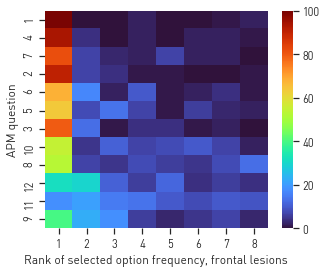

In [76]:
plt.figure(figsize=(5,4))
sns.heatmap(cogni_f, cmap='turbo').set(xlabel='Rank of selected option frequency, frontal lesions', ylabel='APM question')
plt.savefig('cogni_f_2.pdf', bbox_inches='tight')

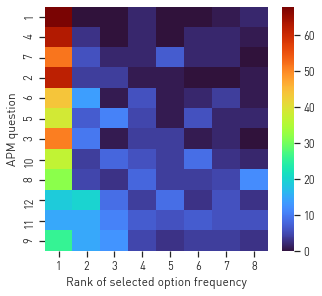

In [156]:
plt.figure(figsize=(5,4.5))
b = sns.heatmap(cogni_f2, cmap='turbo').set(xlabel='Rank of selected option frequency', ylabel='APM question')
plt.savefig('cogni_rf_0322.pdf', bbox_inches='tight')

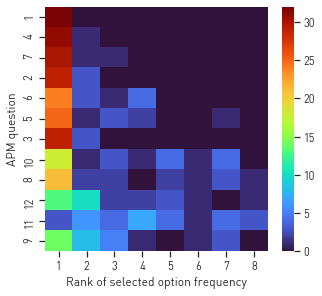

In [78]:
plt.figure(figsize=(5,4.5))
b = sns.heatmap(cogni_f1, cmap='turbo').set(xlabel='Rank of selected option frequency', ylabel='APM question')
plt.savefig('cogni_lf.pdf', bbox_inches='tight')

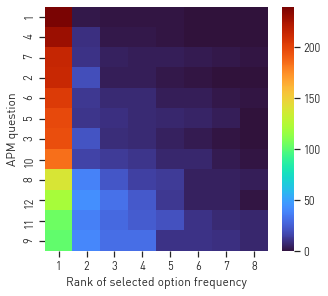

In [155]:
plt.figure(figsize=(5,4.5))
b = sns.heatmap(cogni_h, cmap='turbo').set(xlabel='Rank of selected option frequency', ylabel='APM question')
plt.savefig('cogni_h_0322.pdf', bbox_inches='tight')

In [126]:
df_rf = df[df.sub_group == 2].reset_index(drop=True)
dff_rf = create_apm_summary(df_rf)
dff_rf.to_csv('right_frontal_apm_scores.csv', index=False)

In [ ]:
df_stats_f2[df_stats_f2 < 0.00052]

In [ ]:
df_stats_f2 = cogni_stats(df_h, df_f2, cogni_h, cogni_f2)
df_stats_f2

In [ ]:
#Benjamini/Yekutieli correction
output = fdrcorrection(np.array(df_stats_f2).flatten())
stat_f2 = pd.DataFrame(output[0].reshape(12,8))
stat_f2.index=df_stats_f2.index
stat_f2.columns =df_stats_f2.columns
stat_f2

### image similarity

In [8]:
correct = ['8','4','5','1','2','5','6','3','7','8','7','6']

In [ ]:
files = evaluate_model('/media/amy/disk-11/npsy_apm/apm_images/lama_big_for_comparison/')
metrics = ['hausdorff', 'earthmovers', 'mse', 'ergas', 'nmi']
for f in metrics:
    print(f)
    _ = get_scores_and_duplicates(files, f)
    scores_list = []
names_list = []
totals_list = []
mode_list = []
for f in files.columns[9:]:
    if f == 'nmi':
        scores = get_final_scores(files, f, ascending=False)
        scores = list(reversed(scores))
    else:
        scores = get_final_scores(files, f)
    names_list.append(f)
    scores_list.append(scores)
    total = get_total(scores)[0]
    totals_list.append(total)
scores_frame = pd.DataFrame(scores_list)
scores_frame.columns = scores_frame.columns + 1
scores_frame.index = metrics
for f in scores_frame.columns:
    mode_list.append(scores_frame[f].mode()[0])
print(mode_list)
print("total: " + str(get_total(mode_list)[0]))

In [ ]:
[5, 3, 5, 4, 4, 4, 4, 1, 1, 5, 1, 1]

In [ ]:
[1,1,1,1,0,1,0,1,1,1,1,0]
[1,1,1,0,1,1,1,0,0,1,0,1]
[1,0,1,1,1,1,1,0,0,1,0,0]
[1,1,1,1,1,1,1,0,0,1,0,0]
[1,0,1,1,1,1,1,0,0,1,0,0]

In [ ]:
files = evaluate_model('/media/amy/disk-11/npsy_apm/apm_images/lama_big_reg_for_comparison/')
metrics = ['hausdorff', 'earthmovers', 'mse', 'ergas', 'nmi']
for f in metrics:
    print(f)
    _ = get_scores_and_duplicates(files, f)
    scores_list = []
names_list = []
totals_list = []
mode_list = []
for f in files.columns[9:]:
    if f == 'nmi':
        scores = get_final_scores(files, f, ascending=False)
        scores = list(reversed(scores))
    else:
        scores = get_final_scores(files, f)
    names_list.append(f)
    scores_list.append(scores)
    total = get_total(scores)[0]
    totals_list.append(total)
scores_frame = pd.DataFrame(scores_list)
scores_frame.columns = scores_frame.columns + 1
scores_frame.index = metrics
for f in scores_frame.columns:
    mode_list.append(scores_frame[f].mode()[0])
print(mode_list)
print("total: " + str(get_total(mode_list)[0]))

In [ ]:
files = evaluate_model('/media/amy/disk-11/npsy_apm/apm_images/lama_small_for_comparison/')
metrics = ['hausdorff', 'earthmovers', 'mse', 'ergas', 'nmi']
for f in metrics:
    print(f)
    _ = get_scores_and_duplicates(files, f)
    scores_list = []
names_list = []
totals_list = []
mode_list = []
for f in files.columns[9:]:
    if f == 'nmi':
        scores = get_final_scores(files, f, ascending=False)
        scores = list(reversed(scores))
    else:
        scores = get_final_scores(files, f)
    names_list.append(f)
    scores_list.append(scores)
    total = get_total(scores)[0]
    totals_list.append(total)
scores_frame = pd.DataFrame(scores_list)
scores_frame.columns = scores_frame.columns + 1
scores_frame.index = metrics
for f in scores_frame.columns:
    mode_list.append(scores_frame[f].mode()[0])
print(mode_list)
print("total: " + str(get_total(mode_list)[0]))

### FFC ablated errors matching

In [88]:
df = df[df.r1.notna()]
lama_mode   = ['8', '4', '5', '1', '2', '5', '6', '2', '5', '8', '6', '4']
lama_r_mode = ['8', '1', '3', '7', '3', '7', '2', '7', '5', '4', '3', '4']
lama_s_mode = ['8', '4', '5', '2', '2', '4', '6', '7', '5', '7', '3', '6']
lama_mode_binary = [1,1,1,1,1,1,1,0,0,1,0,0]
lama_r_mode_binary = [1,0,0,0,0,0,0,0,0,0,0,0]
lama_s_mode_binary = [1,1,1,0,1,0,1,0,0,0,0,1]

/home/amy/anaconda3/envs/DNA/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/amy/anaconda3/envs/DNA/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


51.21951219512195 51.16620498614959


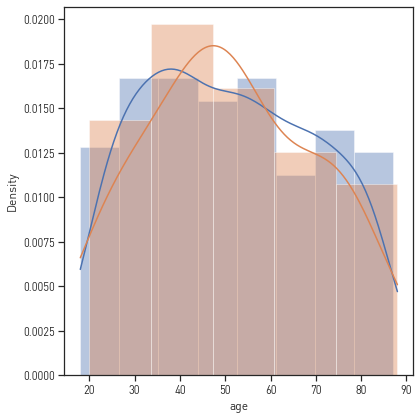

In [92]:
# lama errors
plt.figure(figsize=(6,6))
sns.distplot(df[~((df.r11 == '6') | (df.r12 == '4'))].age,\
             kde_kws={'clip': (18.0, 88.0)})
sns.distplot(df[((df.r11 == '6') | (df.r12 == '4'))].age,\
            kde_kws={'clip': (18.0, 88.0)})
df[~(df.r2 == '1') | (df.r3 == '3') | (df.r4 == '7') | (df.r10 == '4')].median()
df[(df.r2 == '1') | (df.r3 == '3') | (df.r4 == '7') | (df.r10 == '4')].median()
df[(df.r2 == '1') | (df.r3 == '3') | (df.r4 == '7') | (df.r10 == '4')].p2.value_counts()
df[~(df.r2 == '1') | (df.r3 == '3') | (df.r4 == '7')| (df.r10 == '4')].p2.value_counts()
plt.tight_layout()
#comparisons
lama_errs = df[((df.r11 == '6') | (df.r12 == '4'))]
non_lama_errs = df[~((df.r11 == '6') | (df.r12 == '4'))]
print(lama_errs.age.mean(), non_lama_errs.age.mean())

In [205]:
non_lama_errs.age.std()

18.725207883494544

In [204]:
lama_errs.age.std()

18.71565146491293

In [573]:
non_lama_errs.educ_years.std()

2.9902727112278606

In [105]:
obs = np.array([[17, 24], [159, 202]])
chi2, p_val, _, _ = chi2_contingency(obs)
print('gender p-val is: ', p_val, chi2)
obs = np.array([[9, 32], [64, 297]])
chi2, p_val, _, _ = chi2_contingency(obs)
print('right frontal group p-val is: ', p_val, chi2)

gender p-val is:  0.8811063172040992 0.02237026028279817
right frontal group p-val is:  0.6520663083731036 0.20330494847977157


In [94]:
age_stats = mannwhitneyu(lama_errs.age, non_lama_errs.age)
nart_stats = mannwhitneyu(lama_errs.nart.dropna(), non_lama_errs.nart.dropna())
ey_stats = mannwhitneyu(lama_errs.educ_years.dropna(), non_lama_errs.educ_years.dropna())
print('\n age: ' + str(age_stats),
      '\n nart: ' + str(nart_stats), 
      '\n educ_years: '+ str(ey_stats))


 age: MannwhitneyuResult(statistic=7433.0, pvalue=0.9637912462084184) 
 nart: MannwhitneyuResult(statistic=6684.0, pvalue=0.8553425546306703) 
 educ_years: MannwhitneyuResult(statistic=7169.5, pvalue=0.8714800399880093)


/home/amy/anaconda3/envs/DNA/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/home/amy/anaconda3/envs/DNA/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



no with err2: 8  ,no with err3: 12  ,no with err4: 1  ,no with err10: 21
58.5 50.36187845303867


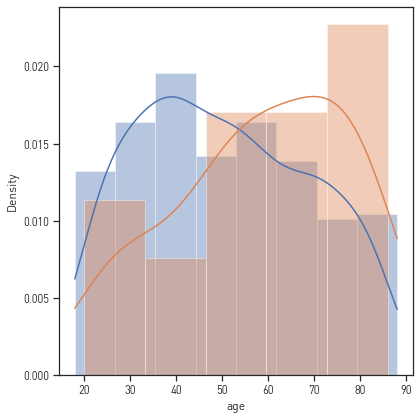

In [160]:
# lama ablated (regular) errors
plt.figure(figsize=(6,6))
sns.distplot(df[~((df.r2 == '1') | (df.r3 == '3') | (df.r4 == '7') | (df.r10 == '4'))].age,\
             kde_kws={'clip': (18.0, 88.0)})
sns.distplot(df[((df.r2 == '1') | (df.r3 == '3') | (df.r4 == '7')| (df.r10 == '4'))].age,\
            kde_kws={'clip': (18.0, 88.0)})
df[~(df.r2 == '1') | (df.r3 == '3') | (df.r4 == '7') | (df.r10 == '4')].median()
df[(df.r2 == '1') | (df.r3 == '3') | (df.r4 == '7') | (df.r10 == '4')].median()
df[(df.r2 == '1') | (df.r3 == '3') | (df.r4 == '7') | (df.r10 == '4')].p2.value_counts()
df[~(df.r2 == '1') | (df.r3 == '3') | (df.r4 == '7')| (df.r10 == '4')].p2.value_counts()
print('no with err2:', len(df[df.r2 == '1']), ' ,no with err3:', len(df[df.r3 == '3']),\
      ' ,no with err4:', len(df[df.r4 == '7']), ' ,no with err10:', len(df[df.r10 == '4']))
plt.tight_layout()
plt.savefig('all_apm_scores_kde_0223.pdf')
#comparisons
nf_errs = df[((df.r2 == '1') | (df.r3 == '3') | (df.r4 == '7') | (df.r10 == '4'))]
non_errs = df[~((df.r2 == '1') | (df.r3 == '3') | (df.r4 == '7')| (df.r10 == '4'))]
print(nf_errs.age.mean(), non_errs.age.mean())

In [223]:
nf_errs_lesions = nf_errs[nf_errs.group != 1].reset_index(drop=True)
non_errs_lesions = non_errs[non_errs.group != 1].reset_index(drop=True)

In [224]:
nf_errs_lesions['fourier_error'] = 1
non_errs_lesions['fourier_error'] = 0

In [225]:
for_james = pd.concat([nf_errs_lesions, non_errs_lesions])
for_james.drop(['patient', 'p1', 'p2'], axis=1, inplace=True)
for_james.to_csv('fast_fourier_patients.csv', index=False)

In [162]:
obs = np.array([[23, 17], [153, 209]])
_, p_val, _, _ = chi2_contingency(obs)
print('gender p-val is: ', p_val)
obs = np.array([[25, 15], [304, 58]])
_, p_val, _, _ = chi2_contingency(obs)
print('right frontal group p-val is: ', p_val)

gender p-val is:  0.09392079448987252
right frontal group p-val is:  0.0017623172290420256


In [165]:
p_vals_all = np.array([0.02237026028279817, 0.20330494847977157, 0.9637912462084184, 0.8553425546306703, 0.8714800399880093,
         0.09392079448987252,0.0017623172290420256, 0.009391030625536813, 0.36305160542124926, 0.4184950050805313,
         0.2573277504098882, 0.325116893630749, 0.0370917260726789, 0.18327432305899582, 0.12658733316895246])
fdrcorrection(p_vals_all)

(array([False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False]),
 array([0.1118513 , 0.38119678, 0.96379125, 0.93372861, 0.93372861,
        0.28176238, 0.02643476, 0.07043273, 0.49507037, 0.52311876,
        0.42887958, 0.48767534, 0.13909397, 0.38119678, 0.31646833]))

In [108]:
non_errs.nart.mean()

107.11363636363636

In [109]:
non_errs.nart.std()

10.180067467054117

In [163]:
age_stats = mannwhitneyu(nf_errs.age, non_errs.age)
nart_stats = mannwhitneyu(nf_errs.nart.dropna(), non_errs.nart.dropna())
ey_stats = mannwhitneyu(nf_errs.educ_years.dropna(), non_errs.educ_years.dropna())
print('\n age: ' + str(age_stats),
      '\n nart: ' + str(nart_stats), 
      '\n educ_years: '+ str(ey_stats))


 age: MannwhitneyuResult(statistic=9051.5, pvalue=0.009391030625536813) 
 nart: MannwhitneyuResult(statistic=6919.0, pvalue=0.36305160542124926) 
 educ_years: MannwhitneyuResult(statistic=6363.5, pvalue=0.4184950050805313)


/home/amy/anaconda3/envs/DNA/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/amy/anaconda3/envs/DNA/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

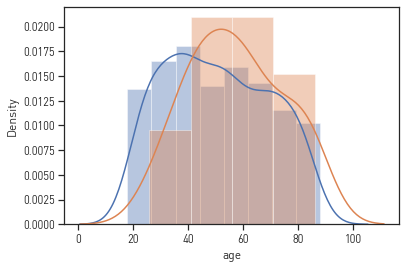

In [100]:
### lama small errors - 4-2, 6-4, 10-7
#errors plot lama small
s_errs = df[((df.r4 == '2') | (df.r6 == '4') | (df.r10 == '7'))]
non_s_errs = df[~((df.r4 == '2') | (df.r6 == '4') | (df.r10 == '7'))]
sns.distplot(df[~((df.r4 == '2') | (df.r6 == '4') | (df.r10 == '7'))].age)
sns.distplot(df[((df.r4 == '2') | (df.r6 == '4') | (df.r10 == '7'))].age)

In [211]:
for col in ['age', 'nart', 'educ_years']:
    print(str(np.round(non_s_errs[col].mean(), decimals=1)) + ' (' + str(np.round(non_s_errs[col].std(), decimals=1)) + ')')

50.6 (18.8)
107.6 (10.0)
14.4 (3.0)


In [110]:
obs = np.array([[19, 16], [157, 210]])
_, p_val, _, _ = chi2_contingency(obs)
print('gender p-val is: ', p_val)
obs = np.array([[9, 26], [64, 303]])
_, p_val, _, _ = chi2_contingency(obs)
print('right frontal group p-val is: ', p_val)

gender p-val is:  0.2573277504098882
right frontal group p-val is:  0.325116893630749


In [111]:
age_stats = mannwhitneyu(s_errs.age, non_s_errs.age)
nart_stats = mannwhitneyu(s_errs.nart.dropna(), non_s_errs.nart.dropna())
ey_stats = mannwhitneyu(s_errs.educ_years.dropna(), non_s_errs.educ_years.dropna())
print('\n age: ' + str(age_stats),
      '\n nart: ' + str(nart_stats), 
      '\n educ_years: '+ str(ey_stats))


 age: MannwhitneyuResult(statistic=7792.0, pvalue=0.0370917260726789) 
 nart: MannwhitneyuResult(statistic=5335.5, pvalue=0.18327432305899582) 
 educ_years: MannwhitneyuResult(statistic=5145.5, pvalue=0.12658733316895246)


In [112]:
non_s_errs.nart.mean()

107.55807365439094

In [113]:
non_s_errs.nart.std()

9.950025623837064

In [ ]:
output = fdrcorrection(np.array(df_stats_f2).flatten())

In [ ]:
# lama ablated (regular) errors
plt.figure(figsize=(6,6))
sns.distplot(df[~((df.r2 == '1') | (df.r3 == '3') | (df.r4 == '7') | (df.r10 == '4'))].age,\
             kde_kws={'clip': (18.0, 88.0)})
sns.distplot(df[((df.r2 == '1') | (df.r3 == '3') | (df.r4 == '7')| (df.r10 == '4'))].age,\
            kde_kws={'clip': (18.0, 88.0)})
df[~(df.r2 == '1') | (df.r3 == '3') | (df.r4 == '7') | (df.r10 == '4')].median()
df[(df.r2 == '1') | (df.r3 == '3') | (df.r4 == '7') | (df.r10 == '4')].median()
df[(df.r2 == '1') | (df.r3 == '3') | (df.r4 == '7') | (df.r10 == '4')].p2.value_counts()
df[~(df.r2 == '1') | (df.r3 == '3') | (df.r4 == '7')| (df.r10 == '4')].p2.value_counts()
print('no with err2:', len(df[df.r2 == '1']), ' ,no with err3:', len(df[df.r3 == '3']),\
      ' ,no with err4:', len(df[df.r4 == '7']), ' ,no with err10:', len(df[df.r10 == '4']))
plt.tight_layout()
plt.savefig('all_apm_scores_kde_0223.pdf')
#comparisons
nf_errs = df[((df.r2 == '1') | (df.r3 == '3') | (df.r4 == '7') | (df.r10 == '4'))]
non_errs = df[~((df.r2 == '1') | (df.r3 == '3') | (df.r4 == '7')| (df.r10 == '4'))]
print(nf_errs.age.mean(), non_errs.age.mean())

In [ ]:
###just healthy and right frontals
# lama ablated (regular) errors
plt.figure(figsize=(6,6))
sns.distplot(df[~((df.r2 == '1') | (df.r3 == '3') | (df.r4 == '7') | (df.r10 == '4'))].age,\
             kde_kws={'clip': (18.0, 88.0)})
sns.distplot(df[((df.r2 == '1') | (df.r3 == '3') | (df.r4 == '7')| (df.r10 == '4'))].age,\
            kde_kws={'clip': (18.0, 88.0)})
df[~(df.r2 == '1') | (df.r3 == '3') | (df.r4 == '7') | (df.r10 == '4')].median()
df[(df.r2 == '1') | (df.r3 == '3') | (df.r4 == '7') | (df.r10 == '4')].median()
df[(df.r2 == '1') | (df.r3 == '3') | (df.r4 == '7') | (df.r10 == '4')].p2.value_counts()
df[~(df.r2 == '1') | (df.r3 == '3') | (df.r4 == '7')| (df.r10 == '4')].p2.value_counts()
print('no with err2:', len(df[df.r2 == '1']), ' ,no with err3:', len(df[df.r3 == '3']),\
      ' ,no with err4:', len(df[df.r4 == '7']), ' ,no with err10:', len(df[df.r10 == '4']))
plt.tight_layout()
plt.savefig('all_apm_scores_kde_0223.pdf')
#comparisons
nf_errs = df[((df.r2 == '1') | (df.r3 == '3') | (df.r4 == '7') | (df.r10 == '4'))]
non_errs = df[~((df.r2 == '1') | (df.r3 == '3') | (df.r4 == '7')| (df.r10 == '4'))]
print(nf_errs.age.mean(), non_errs.age.mean())

### Animal synapse comparison

In [148]:
ani_df = pd.read_csv('animal_synapses.csv')

In [171]:
adf = ani_df[ani_df.animal !='LaMa']
adf.columns = ['Animal', 'Synapses']

/home/amy/anaconda3/envs/DNA/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


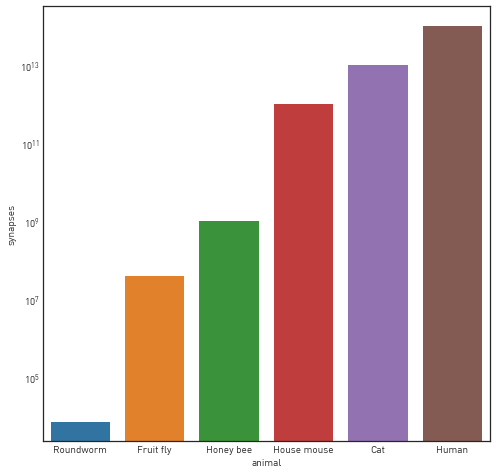

In [150]:
plt.figure(figsize=(8,8))
sns.barplot(adf.animal, adf.synapses).set_yscale("log")

In [213]:
adf['Parameters'] = adf['Synapses']

/home/amy/anaconda3/envs/DNA/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


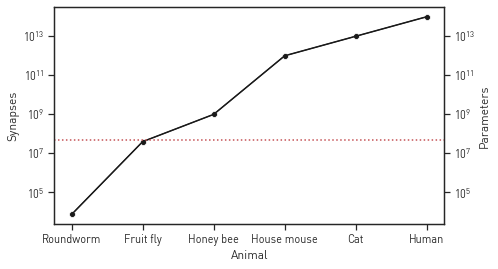

In [222]:
#plt.style.use('ticks')
sns.set_theme()
sns.set_style("ticks")
plt.rcParams['font.sans-serif'] = "DinPro"
plt.rcParams['font.family'] = "DinPro"
plt.figure(figsize=(7,4))
sns.lineplot(x='Animal', y='Synapses', data=adf, marker='o', linewidth=1, color='k').set_yscale("log")
ax2 = plt.twinx()
sns.lineplot(x='Animal', y='Parameters', data=adf, ax=ax2, color='k').set_yscale("log")
plt.axhline(y=50000000, color='r', linestyle=':') 
plt.savefig('animal_synapses_log.svg')

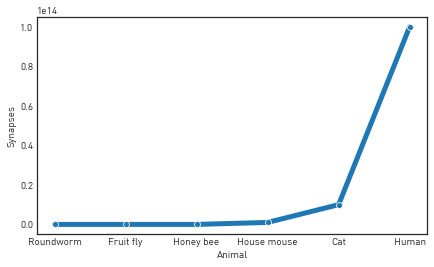

In [175]:
plt.figure(figsize=(7,4))
sns.lineplot(x='Animal', y='Synapses', data=adf, marker='o', linewidth=5)
plt.savefig('animal_synapses.svg')

### Lama code

from https://github.com/saic-mdal/lama#prediction
(inpenv) (base) ➜  lama git:(main) ✗ python3 bin/predict.py model.path=$(pwd)/lama-fourier indir=$(pwd)/apm_deres outdir=$(pwd)/output_deres


- (base) ➜  ~ source activate gt
(gt) ➜  ~ pip install lama-cleaner



In [260]:
#create lama infolder: blanks and normal
inpath = '/home/amy/Documents/npsy_apm/apm_images/deres_square/'
outpath = '/home/amy/lama/input_512/'
files = pd.DataFrame([f for f in os.listdir(inpath)if os.path.isfile(os.path.join(inpath, f))])
files.columns = ['filename']

for i in range(0,10):
    for f in files['filename']:
        shutil.copyfile(inpath + f, outpath + str(i) + f)